In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Dataset

In [4]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset[:]
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


### Dataset Information

In [5]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [6]:
# specify the number of lag hours
n_hours = 24*7
K = 24

#### Stage

In [7]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [8]:
stages_supervised

,var1(t-168),var2(t-168),var3(t-168),var4(t-168),var1(t-167),var2(t-167),var3(t-167),var4(t-167),var1(t-166),var2(t-166),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/8/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,-0.22,-0.30,-0.60,-0.38,-0.41,-0.44,-0.42,-0.26,-0.24,-0.31
1/8/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,-0.41,-0.44,-0.42,-0.26,-0.24,-0.31,0.10,0.25,0.29,0.25
1/8/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,-0.24,-0.31,0.10,0.25,0.29,0.25,0.66,0.82,0.86,0.78
1/8/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,0.29,0.25,0.66,0.82,0.86,0.78,1.10,1.24,1.30,1.22
1/8/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,0.86,0.78,1.10,1.24,1.30,1.22,1.49,1.62,1.68,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.04,1.07,1.13,1.060,0.73,0.75,0.83,0.80,0.42,0.39,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,0.73,0.75,0.83,0.800,0.42,0.39,0.46,0.49,0.49,0.48,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.42,0.39,0.46,0.490,0.49,0.48,0.55,0.50,0.83,0.80,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


In [9]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# # stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

In [10]:
# stages_head_supervised

#### Non-stage

In [11]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [12]:
# non_stages_supervised

In [13]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [14]:
# non_stages_supervised_cut

### N_out, N_in, K

In [15]:
# specify the number of lag hours
# n_hours = 72
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [16]:
n_features

11

### Concatenation

In [17]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [18]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


In [19]:
# all_concat = pd.DataFrame(all_data)
# all_concat

In [20]:
# all_concat.iloc[:, -12:]

### Train & Test set

In [21]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 76992


In [22]:
train.shape

(76992, 1944)

In [23]:
# test set (10/16/2018 - 12/30/3020)
# data.iloc[462368:, :]

### Normalization

In [24]:
n_hours

168

In [25]:
n_features

11

In [26]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [27]:
n_obs

1848

In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

- SimpleRNN(64), no dropout, activation=relu, 2000 epoch --> 0.0016

In [35]:
# Simple RNN Model
model_rnn_60 = keras.Sequential()

# model_rnn_60.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn_60.add(layers.SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model_rnn_60.add(layers.Dense(8, activation='relu'))
model_rnn_60.add(layers.Dense(train_y.shape[1]))   # Regression -> No Need for Activation
model_rnn_60.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 128)               17920     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                12384     
Total params: 30,304
Trainable params: 30,304
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000

Epoch 00001: val_mae improved from inf to 0.44084, saving model to saved_model/rnn_11.h5
151/151 - 14s - loss: 0.1499 - mae: 0.3362 - val_loss: 0.2555 - val_mae: 0.4408
Epoch 2/2000

Epoch 00002: val_mae improved from 0.44084 to 0.39929, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.1283 - mae: 0.3073 - val_loss: 0.2176 - val_mae: 0.3993
Epoch 3/2000

Epoch 00003: val_mae improved from 0.39929 to 0.33833, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.1050 - mae: 0.2707 - val_loss: 0.1689 - val_mae: 0.3383
Epoch 4/2000

Epoch 00004: val_mae improved from 0.33833 to 0.25986, saving model to saved_model/rnn_11.h5
151/151 - 14s - loss: 0.0751 - mae: 0.2178 - val_loss: 0.1115 - val_mae: 0.2599
Epoch 5/2000

Epoch 00005: val_mae improved from 0.25986 to 0.21577, saving model to saved_model/rnn_11.h5
151/151 - 14s - loss: 0.0517 - mae: 0.1761 - val_loss: 0.0782 - val_mae: 0.2158
Epoch 6/2000

Epoch 00006: val_mae improved from 0.21577 to 0.18351, 

Epoch 45/2000

Epoch 00045: val_mae improved from 0.04674 to 0.04658, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0034 - val_mae: 0.0466
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04658 to 0.04644, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0034 - val_mae: 0.0464
Epoch 47/2000

Epoch 00047: val_mae improved from 0.04644 to 0.04631, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 0.0013 - mae: 0.0274 - val_loss: 0.0034 - val_mae: 0.0463
Epoch 48/2000

Epoch 00048: val_mae improved from 0.04631 to 0.04619, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0033 - val_mae: 0.0462
Epoch 49/2000

Epoch 00049: val_mae improved from 0.04619 to 0.04607, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0033 - val_mae: 0.0461
Epoch 50/2000

Epoch 00050: val_mae improved from 0.04607 to

Epoch 89/2000

Epoch 00089: val_mae improved from 0.04292 to 0.04285, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0029 - val_mae: 0.0429
Epoch 90/2000

Epoch 00090: val_mae improved from 0.04285 to 0.04279, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 91/2000

Epoch 00091: val_mae improved from 0.04279 to 0.04272, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0029 - val_mae: 0.0427
Epoch 92/2000

Epoch 00092: val_mae improved from 0.04272 to 0.04265, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0029 - val_mae: 0.0427
Epoch 93/2000

Epoch 00093: val_mae improved from 0.04265 to 0.04259, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0028 - val_mae: 0.0426
Epoch 94/2000

Epoch 00094: val_mae improved from 0.04259 to

Epoch 133/2000

Epoch 00133: val_mae improved from 0.04020 to 0.04015, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0025 - val_mae: 0.0401
Epoch 134/2000

Epoch 00134: val_mae improved from 0.04015 to 0.04010, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0025 - val_mae: 0.0401
Epoch 135/2000

Epoch 00135: val_mae improved from 0.04010 to 0.04005, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0025 - val_mae: 0.0400
Epoch 136/2000

Epoch 00136: val_mae improved from 0.04005 to 0.04000, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0025 - val_mae: 0.0400
Epoch 137/2000

Epoch 00137: val_mae improved from 0.04000 to 0.03995, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0025 - val_mae: 0.0399
Epoch 138/2000

Epoch 00138: val_mae improved from 0.03

Epoch 177/2000

Epoch 00177: val_mae improved from 0.03815 to 0.03811, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 9.8131e-04 - mae: 0.0232 - val_loss: 0.0023 - val_mae: 0.0381
Epoch 178/2000

Epoch 00178: val_mae improved from 0.03811 to 0.03806, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 9.7944e-04 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0381
Epoch 179/2000

Epoch 00179: val_mae improved from 0.03806 to 0.03801, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 9.7756e-04 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0380
Epoch 180/2000

Epoch 00180: val_mae improved from 0.03801 to 0.03797, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 9.7568e-04 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0380
Epoch 181/2000

Epoch 00181: val_mae improved from 0.03797 to 0.03792, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 9.7378e-04 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0379
Epoch 182/2000

Epoch 00182: val_ma

Epoch 220/2000

Epoch 00220: val_mae improved from 0.03604 to 0.03600, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.9650e-04 - mae: 0.0219 - val_loss: 0.0020 - val_mae: 0.0360
Epoch 221/2000

Epoch 00221: val_mae improved from 0.03600 to 0.03596, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.9470e-04 - mae: 0.0219 - val_loss: 0.0020 - val_mae: 0.0360
Epoch 222/2000

Epoch 00222: val_mae improved from 0.03596 to 0.03592, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 8.9291e-04 - mae: 0.0218 - val_loss: 0.0020 - val_mae: 0.0359
Epoch 223/2000

Epoch 00223: val_mae improved from 0.03592 to 0.03588, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.9115e-04 - mae: 0.0218 - val_loss: 0.0020 - val_mae: 0.0359
Epoch 224/2000

Epoch 00224: val_mae improved from 0.03588 to 0.03584, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.8942e-04 - mae: 0.0218 - val_loss: 0.0020 - val_mae: 0.0358
Epoch 225/2000

Epoch 00225: val_ma

Epoch 263/2000

Epoch 00263: val_mae improved from 0.03477 to 0.03475, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.3777e-04 - mae: 0.0210 - val_loss: 0.0019 - val_mae: 0.0348
Epoch 264/2000

Epoch 00264: val_mae improved from 0.03475 to 0.03473, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.3678e-04 - mae: 0.0210 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 265/2000

Epoch 00265: val_mae improved from 0.03473 to 0.03471, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 8.3580e-04 - mae: 0.0210 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 266/2000

Epoch 00266: val_mae improved from 0.03471 to 0.03469, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 8.3483e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 267/2000

Epoch 00267: val_mae improved from 0.03469 to 0.03466, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.3388e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 268/2000

Epoch 00268: val_ma

Epoch 306/2000

Epoch 00306: val_mae improved from 0.03399 to 0.03398, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.0331e-04 - mae: 0.0205 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 307/2000

Epoch 00307: val_mae improved from 0.03398 to 0.03397, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.0266e-04 - mae: 0.0205 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 308/2000

Epoch 00308: val_mae improved from 0.03397 to 0.03395, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 8.0201e-04 - mae: 0.0205 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 309/2000

Epoch 00309: val_mae improved from 0.03395 to 0.03394, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 8.0138e-04 - mae: 0.0204 - val_loss: 0.0018 - val_mae: 0.0339
Epoch 310/2000

Epoch 00310: val_mae improved from 0.03394 to 0.03392, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 8.0074e-04 - mae: 0.0204 - val_loss: 0.0018 - val_mae: 0.0339
Epoch 311/2000

Epoch 00311: val_ma

Epoch 349/2000

Epoch 00349: val_mae improved from 0.03345 to 0.03344, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.7864e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 350/2000

Epoch 00350: val_mae improved from 0.03344 to 0.03343, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.7814e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 351/2000

Epoch 00351: val_mae improved from 0.03343 to 0.03342, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.7763e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 352/2000

Epoch 00352: val_mae improved from 0.03342 to 0.03341, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.7712e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 353/2000

Epoch 00353: val_mae improved from 0.03341 to 0.03340, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.7662e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 354/2000

Epoch 00354: val_ma

Epoch 392/2000

Epoch 00392: val_mae improved from 0.03300 to 0.03299, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.5848e-04 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 393/2000

Epoch 00393: val_mae improved from 0.03299 to 0.03298, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.5804e-04 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 394/2000

Epoch 00394: val_mae improved from 0.03298 to 0.03297, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 7.5761e-04 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 395/2000

Epoch 00395: val_mae improved from 0.03297 to 0.03296, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.5718e-04 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 396/2000

Epoch 00396: val_mae improved from 0.03296 to 0.03296, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 7.5675e-04 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 397/2000

Epoch 00397: val_ma

Epoch 435/2000

Epoch 00435: val_mae improved from 0.03264 to 0.03264, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 7.4116e-04 - mae: 0.0196 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 436/2000

Epoch 00436: val_mae improved from 0.03264 to 0.03263, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 7.4079e-04 - mae: 0.0196 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 437/2000

Epoch 00437: val_mae improved from 0.03263 to 0.03262, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.4042e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 438/2000

Epoch 00438: val_mae improved from 0.03262 to 0.03262, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.4005e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 439/2000

Epoch 00439: val_mae improved from 0.03262 to 0.03261, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.3968e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 440/2000

Epoch 00440: val_ma

Epoch 478/2000

Epoch 00478: val_mae improved from 0.03237 to 0.03236, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.2616e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 479/2000

Epoch 00479: val_mae improved from 0.03236 to 0.03235, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.2584e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 480/2000

Epoch 00480: val_mae improved from 0.03235 to 0.03235, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.2551e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 481/2000

Epoch 00481: val_mae improved from 0.03235 to 0.03234, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.2519e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 482/2000

Epoch 00482: val_mae improved from 0.03234 to 0.03234, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.2487e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 483/2000

Epoch 00483: val_ma

Epoch 521/2000

Epoch 00521: val_mae improved from 0.03212 to 0.03211, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.1317e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 522/2000

Epoch 00522: val_mae improved from 0.03211 to 0.03211, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.1289e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 523/2000

Epoch 00523: val_mae improved from 0.03211 to 0.03210, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.1261e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 524/2000

Epoch 00524: val_mae improved from 0.03210 to 0.03209, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.1232e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 525/2000

Epoch 00525: val_mae improved from 0.03209 to 0.03209, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.1205e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 526/2000

Epoch 00526: val_ma

Epoch 564/2000

Epoch 00564: val_mae improved from 0.03188 to 0.03188, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.0184e-04 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 565/2000

Epoch 00565: val_mae improved from 0.03188 to 0.03188, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.0159e-04 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 566/2000

Epoch 00566: val_mae improved from 0.03188 to 0.03187, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.0135e-04 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 567/2000

Epoch 00567: val_mae improved from 0.03187 to 0.03186, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.0110e-04 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 568/2000

Epoch 00568: val_mae improved from 0.03186 to 0.03186, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 7.0086e-04 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 569/2000

Epoch 00569: val_ma

Epoch 607/2000

Epoch 00607: val_mae improved from 0.03169 to 0.03168, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.9182e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 608/2000

Epoch 00608: val_mae improved from 0.03168 to 0.03168, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.9160e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 609/2000

Epoch 00609: val_mae improved from 0.03168 to 0.03168, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.9138e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 610/2000

Epoch 00610: val_mae improved from 0.03168 to 0.03167, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.9116e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 611/2000

Epoch 00611: val_mae improved from 0.03167 to 0.03167, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.9094e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 612/2000

Epoch 00612: val_ma

Epoch 650/2000

Epoch 00650: val_mae improved from 0.03150 to 0.03150, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.8265e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 651/2000

Epoch 00651: val_mae improved from 0.03150 to 0.03149, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.8245e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 652/2000

Epoch 00652: val_mae improved from 0.03149 to 0.03149, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 6.8225e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 653/2000

Epoch 00653: val_mae improved from 0.03149 to 0.03148, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.8204e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 654/2000

Epoch 00654: val_mae improved from 0.03148 to 0.03148, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.8183e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 655/2000

Epoch 00655: val_ma

Epoch 693/2000

Epoch 00693: val_mae improved from 0.03130 to 0.03130, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.7383e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 694/2000

Epoch 00694: val_mae improved from 0.03130 to 0.03129, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.7362e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 695/2000

Epoch 00695: val_mae improved from 0.03129 to 0.03129, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.7342e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 696/2000

Epoch 00696: val_mae improved from 0.03129 to 0.03128, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.7321e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 697/2000

Epoch 00697: val_mae improved from 0.03128 to 0.03128, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.7300e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 698/2000

Epoch 00698: val_ma

Epoch 736/2000

Epoch 00736: val_mae improved from 0.03115 to 0.03115, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 6.6407e-04 - mae: 0.0184 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 737/2000

Epoch 00737: val_mae improved from 0.03115 to 0.03114, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.6383e-04 - mae: 0.0184 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 738/2000

Epoch 00738: val_mae improved from 0.03114 to 0.03114, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 6.6359e-04 - mae: 0.0184 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 739/2000

Epoch 00739: val_mae improved from 0.03114 to 0.03114, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 6.6335e-04 - mae: 0.0184 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 740/2000

Epoch 00740: val_mae did not improve from 0.03114
151/151 - 12s - loss: 6.6310e-04 - mae: 0.0184 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 741/2000

Epoch 00741: val_mae improved from 0.03114 to 0.03114, saving 

Epoch 779/2000

Epoch 00779: val_mae improved from 0.03106 to 0.03106, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.5303e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 780/2000

Epoch 00780: val_mae improved from 0.03106 to 0.03106, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 6.5273e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 781/2000

Epoch 00781: val_mae improved from 0.03106 to 0.03106, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.5244e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 782/2000

Epoch 00782: val_mae improved from 0.03106 to 0.03105, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 6.5215e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 783/2000

Epoch 00783: val_mae improved from 0.03105 to 0.03105, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.5185e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 784/2000

Epoch 00784: val_ma

Epoch 822/2000

Epoch 00822: val_mae improved from 0.03080 to 0.03079, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.3297e-04 - mae: 0.0179 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 823/2000

Epoch 00823: val_mae improved from 0.03079 to 0.03078, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.3220e-04 - mae: 0.0179 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 824/2000

Epoch 00824: val_mae improved from 0.03078 to 0.03077, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.3143e-04 - mae: 0.0179 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 825/2000

Epoch 00825: val_mae improved from 0.03077 to 0.03076, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.3064e-04 - mae: 0.0179 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 826/2000

Epoch 00826: val_mae improved from 0.03076 to 0.03074, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 6.2983e-04 - mae: 0.0179 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 827/2000

Epoch 00827: val_ma

Epoch 865/2000

Epoch 00865: val_mae improved from 0.02997 to 0.02995, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.9471e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 866/2000

Epoch 00866: val_mae improved from 0.02995 to 0.02992, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.9371e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 867/2000

Epoch 00867: val_mae improved from 0.02992 to 0.02990, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.9271e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 868/2000

Epoch 00868: val_mae improved from 0.02990 to 0.02988, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.9171e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 869/2000

Epoch 00869: val_mae improved from 0.02988 to 0.02985, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 5.9071e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 870/2000

Epoch 00870: val_ma

Epoch 908/2000

Epoch 00908: val_mae improved from 0.02906 to 0.02904, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 5.5421e-04 - mae: 0.0166 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 909/2000

Epoch 00909: val_mae improved from 0.02904 to 0.02902, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.5337e-04 - mae: 0.0166 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 910/2000

Epoch 00910: val_mae improved from 0.02902 to 0.02900, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.5252e-04 - mae: 0.0166 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 911/2000

Epoch 00911: val_mae improved from 0.02900 to 0.02898, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.5169e-04 - mae: 0.0166 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 912/2000

Epoch 00912: val_mae improved from 0.02898 to 0.02896, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 5.5086e-04 - mae: 0.0165 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 913/2000

Epoch 00913: val_ma

Epoch 951/2000

Epoch 00951: val_mae improved from 0.02827 to 0.02825, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.2202e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 952/2000

Epoch 00952: val_mae improved from 0.02825 to 0.02823, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 5.2135e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 953/2000

Epoch 00953: val_mae improved from 0.02823 to 0.02821, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 5.2068e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 954/2000

Epoch 00954: val_mae improved from 0.02821 to 0.02820, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.2001e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 955/2000

Epoch 00955: val_mae improved from 0.02820 to 0.02818, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 5.1935e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 956/2000

Epoch 00956: val_ma

Epoch 994/2000

Epoch 00994: val_mae improved from 0.02758 to 0.02756, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.9661e-04 - mae: 0.0156 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 995/2000

Epoch 00995: val_mae improved from 0.02756 to 0.02754, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.9608e-04 - mae: 0.0156 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 996/2000

Epoch 00996: val_mae improved from 0.02754 to 0.02753, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.9555e-04 - mae: 0.0156 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 997/2000

Epoch 00997: val_mae improved from 0.02753 to 0.02751, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.9502e-04 - mae: 0.0155 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 998/2000

Epoch 00998: val_mae improved from 0.02751 to 0.02749, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.9450e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 999/2000

Epoch 00999: val_ma

Epoch 1037/2000

Epoch 01037: val_mae improved from 0.02693 to 0.02692, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.7572e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 1038/2000

Epoch 01038: val_mae improved from 0.02692 to 0.02691, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.7528e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 1039/2000

Epoch 01039: val_mae improved from 0.02691 to 0.02690, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.7485e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 1040/2000

Epoch 01040: val_mae improved from 0.02690 to 0.02688, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.7439e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 1041/2000

Epoch 01041: val_mae improved from 0.02688 to 0.02686, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.7394e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 1042/2000

Epoch 01042: 

Epoch 1080/2000

Epoch 01080: val_mae improved from 0.02634 to 0.02633, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.5767e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1081/2000

Epoch 01081: val_mae improved from 0.02633 to 0.02631, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.5729e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1082/2000

Epoch 01082: val_mae improved from 0.02631 to 0.02630, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.5686e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1083/2000

Epoch 01083: val_mae improved from 0.02630 to 0.02629, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.5647e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1084/2000

Epoch 01084: val_mae improved from 0.02629 to 0.02627, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.5608e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1085/2000

Epoch 01085: 

Epoch 1123/2000

Epoch 01123: val_mae improved from 0.02584 to 0.02583, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.4196e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 1124/2000

Epoch 01124: val_mae improved from 0.02583 to 0.02582, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.4162e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 1125/2000

Epoch 01125: val_mae improved from 0.02582 to 0.02581, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.4130e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 1126/2000

Epoch 01126: val_mae improved from 0.02581 to 0.02580, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.4094e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 1127/2000

Epoch 01127: val_mae improved from 0.02580 to 0.02579, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.4061e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 1128/2000

Epoch 01128: 

Epoch 1166/2000

Epoch 01166: val_mae improved from 0.02546 to 0.02545, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.2845e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 1167/2000

Epoch 01167: val_mae improved from 0.02545 to 0.02544, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.2814e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 1168/2000

Epoch 01168: val_mae improved from 0.02544 to 0.02543, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.2783e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 1169/2000

Epoch 01169: val_mae improved from 0.02543 to 0.02542, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.2754e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 1170/2000

Epoch 01170: val_mae improved from 0.02542 to 0.02541, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.2727e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 1171/2000

Epoch 01171: 

Epoch 1209/2000

Epoch 01209: val_mae improved from 0.02514 to 0.02514, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.1678e-04 - mae: 0.0141 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 1210/2000

Epoch 01210: val_mae improved from 0.02514 to 0.02513, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.1653e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 1211/2000

Epoch 01211: val_mae improved from 0.02513 to 0.02512, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.1628e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 1212/2000

Epoch 01212: val_mae improved from 0.02512 to 0.02512, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 4.1602e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 1213/2000

Epoch 01213: val_mae improved from 0.02512 to 0.02511, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.1575e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 1214/2000

Epoch 01214: 

Epoch 1252/2000

Epoch 01252: val_mae improved from 0.02489 to 0.02489, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.0655e-04 - mae: 0.0139 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 1253/2000

Epoch 01253: val_mae improved from 0.02489 to 0.02488, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.0632e-04 - mae: 0.0139 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 1254/2000

Epoch 01254: val_mae improved from 0.02488 to 0.02487, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.0607e-04 - mae: 0.0139 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 1255/2000

Epoch 01255: val_mae improved from 0.02487 to 0.02487, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.0585e-04 - mae: 0.0139 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 1256/2000

Epoch 01256: val_mae improved from 0.02487 to 0.02486, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 4.0563e-04 - mae: 0.0139 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 1257/2000

Epoch 01257: 

Epoch 1295/2000

Epoch 01295: val_mae improved from 0.02467 to 0.02467, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.9749e-04 - mae: 0.0137 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 1296/2000

Epoch 01296: val_mae did not improve from 0.02467
151/151 - 12s - loss: 3.9731e-04 - mae: 0.0137 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 1297/2000

Epoch 01297: val_mae did not improve from 0.02467
151/151 - 12s - loss: 3.9714e-04 - mae: 0.0137 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 1298/2000

Epoch 01298: val_mae improved from 0.02467 to 0.02466, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.9695e-04 - mae: 0.0137 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 1299/2000

Epoch 01299: val_mae improved from 0.02466 to 0.02466, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.9676e-04 - mae: 0.0137 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 1300/2000

Epoch 01300: val_mae improved from 0.02466 to 0.02465, saving model to saved_model/rnn_11.h5
151/15

Epoch 1338/2000

Epoch 01338: val_mae improved from 0.02443 to 0.02442, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8885e-04 - mae: 0.0136 - val_loss: 9.9866e-04 - val_mae: 0.0244
Epoch 1339/2000

Epoch 01339: val_mae improved from 0.02442 to 0.02441, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8866e-04 - mae: 0.0136 - val_loss: 9.9803e-04 - val_mae: 0.0244
Epoch 1340/2000

Epoch 01340: val_mae improved from 0.02441 to 0.02441, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8846e-04 - mae: 0.0136 - val_loss: 9.9791e-04 - val_mae: 0.0244
Epoch 1341/2000

Epoch 01341: val_mae improved from 0.02441 to 0.02441, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8830e-04 - mae: 0.0135 - val_loss: 9.9773e-04 - val_mae: 0.0244
Epoch 1342/2000

Epoch 01342: val_mae improved from 0.02441 to 0.02441, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8812e-04 - mae: 0.0135 - val_loss: 9.9772e-04 - val_mae: 0.0244
Epoch 1343

Epoch 1380/2000

Epoch 01380: val_mae improved from 0.02423 to 0.02422, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8079e-04 - mae: 0.0134 - val_loss: 9.8485e-04 - val_mae: 0.0242
Epoch 1381/2000

Epoch 01381: val_mae improved from 0.02422 to 0.02422, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8059e-04 - mae: 0.0134 - val_loss: 9.8479e-04 - val_mae: 0.0242
Epoch 1382/2000

Epoch 01382: val_mae improved from 0.02422 to 0.02421, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8040e-04 - mae: 0.0134 - val_loss: 9.8443e-04 - val_mae: 0.0242
Epoch 1383/2000

Epoch 01383: val_mae improved from 0.02421 to 0.02420, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8021e-04 - mae: 0.0134 - val_loss: 9.8372e-04 - val_mae: 0.0242
Epoch 1384/2000

Epoch 01384: val_mae improved from 0.02420 to 0.02420, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.8001e-04 - mae: 0.0134 - val_loss: 9.8349e-04 - val_mae: 0.0242
Epoch 1385

Epoch 1422/2000

Epoch 01422: val_mae improved from 0.02400 to 0.02400, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.7306e-04 - mae: 0.0133 - val_loss: 9.7035e-04 - val_mae: 0.0240
Epoch 1423/2000

Epoch 01423: val_mae improved from 0.02400 to 0.02399, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.7287e-04 - mae: 0.0133 - val_loss: 9.7009e-04 - val_mae: 0.0240
Epoch 1424/2000

Epoch 01424: val_mae improved from 0.02399 to 0.02399, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.7271e-04 - mae: 0.0133 - val_loss: 9.6980e-04 - val_mae: 0.0240
Epoch 1425/2000

Epoch 01425: val_mae improved from 0.02399 to 0.02398, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.7252e-04 - mae: 0.0133 - val_loss: 9.6911e-04 - val_mae: 0.0240
Epoch 1426/2000

Epoch 01426: val_mae improved from 0.02398 to 0.02397, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.7231e-04 - mae: 0.0133 - val_loss: 9.6866e-04 - val_mae: 0.0240
Epoch 1427

Epoch 1464/2000

Epoch 01464: val_mae improved from 0.02380 to 0.02379, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.6571e-04 - mae: 0.0131 - val_loss: 9.5701e-04 - val_mae: 0.0238
Epoch 1465/2000

Epoch 01465: val_mae improved from 0.02379 to 0.02379, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.6554e-04 - mae: 0.0131 - val_loss: 9.5674e-04 - val_mae: 0.0238
Epoch 1466/2000

Epoch 01466: val_mae improved from 0.02379 to 0.02379, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.6537e-04 - mae: 0.0131 - val_loss: 9.5642e-04 - val_mae: 0.0238
Epoch 1467/2000

Epoch 01467: val_mae improved from 0.02379 to 0.02378, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.6520e-04 - mae: 0.0131 - val_loss: 9.5611e-04 - val_mae: 0.0238
Epoch 1468/2000

Epoch 01468: val_mae improved from 0.02378 to 0.02378, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.6503e-04 - mae: 0.0131 - val_loss: 9.5575e-04 - val_mae: 0.0238
Epoch 1469

Epoch 1506/2000

Epoch 01506: val_mae improved from 0.02359 to 0.02359, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5895e-04 - mae: 0.0130 - val_loss: 9.4303e-04 - val_mae: 0.0236
Epoch 1507/2000

Epoch 01507: val_mae improved from 0.02359 to 0.02358, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5880e-04 - mae: 0.0130 - val_loss: 9.4268e-04 - val_mae: 0.0236
Epoch 1508/2000

Epoch 01508: val_mae improved from 0.02358 to 0.02358, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.5864e-04 - mae: 0.0130 - val_loss: 9.4225e-04 - val_mae: 0.0236
Epoch 1509/2000

Epoch 01509: val_mae improved from 0.02358 to 0.02357, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5849e-04 - mae: 0.0130 - val_loss: 9.4205e-04 - val_mae: 0.0236
Epoch 1510/2000

Epoch 01510: val_mae improved from 0.02357 to 0.02357, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5834e-04 - mae: 0.0130 - val_loss: 9.4176e-04 - val_mae: 0.0236
Epoch 1511

Epoch 1548/2000

Epoch 01548: val_mae improved from 0.02341 to 0.02341, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5263e-04 - mae: 0.0129 - val_loss: 9.3191e-04 - val_mae: 0.0234
Epoch 1549/2000

Epoch 01549: val_mae improved from 0.02341 to 0.02341, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5248e-04 - mae: 0.0129 - val_loss: 9.3161e-04 - val_mae: 0.0234
Epoch 1550/2000

Epoch 01550: val_mae improved from 0.02341 to 0.02340, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5233e-04 - mae: 0.0129 - val_loss: 9.3119e-04 - val_mae: 0.0234
Epoch 1551/2000

Epoch 01551: val_mae improved from 0.02340 to 0.02340, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5218e-04 - mae: 0.0129 - val_loss: 9.3088e-04 - val_mae: 0.0234
Epoch 1552/2000

Epoch 01552: val_mae improved from 0.02340 to 0.02339, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.5203e-04 - mae: 0.0129 - val_loss: 9.3063e-04 - val_mae: 0.0234
Epoch 1553

Epoch 1590/2000

Epoch 01590: val_mae improved from 0.02322 to 0.02322, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4676e-04 - mae: 0.0128 - val_loss: 9.1932e-04 - val_mae: 0.0232
Epoch 1591/2000

Epoch 01591: val_mae improved from 0.02322 to 0.02321, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4663e-04 - mae: 0.0128 - val_loss: 9.1905e-04 - val_mae: 0.0232
Epoch 1592/2000

Epoch 01592: val_mae improved from 0.02321 to 0.02321, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4649e-04 - mae: 0.0128 - val_loss: 9.1907e-04 - val_mae: 0.0232
Epoch 1593/2000

Epoch 01593: val_mae improved from 0.02321 to 0.02321, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.4635e-04 - mae: 0.0128 - val_loss: 9.1874e-04 - val_mae: 0.0232
Epoch 1594/2000

Epoch 01594: val_mae improved from 0.02321 to 0.02320, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 3.4621e-04 - mae: 0.0127 - val_loss: 9.1846e-04 - val_mae: 0.0232
Epoch 1595

Epoch 1632/2000

Epoch 01632: val_mae improved from 0.02306 to 0.02306, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4136e-04 - mae: 0.0126 - val_loss: 9.0896e-04 - val_mae: 0.0231
Epoch 1633/2000

Epoch 01633: val_mae improved from 0.02306 to 0.02305, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4123e-04 - mae: 0.0126 - val_loss: 9.0877e-04 - val_mae: 0.0231
Epoch 1634/2000

Epoch 01634: val_mae improved from 0.02305 to 0.02305, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4110e-04 - mae: 0.0126 - val_loss: 9.0872e-04 - val_mae: 0.0230
Epoch 1635/2000

Epoch 01635: val_mae improved from 0.02305 to 0.02305, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4099e-04 - mae: 0.0126 - val_loss: 9.0848e-04 - val_mae: 0.0230
Epoch 1636/2000

Epoch 01636: val_mae improved from 0.02305 to 0.02304, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.4086e-04 - mae: 0.0126 - val_loss: 9.0795e-04 - val_mae: 0.0230
Epoch 1637

Epoch 1674/2000

Epoch 01674: val_mae improved from 0.02290 to 0.02289, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3634e-04 - mae: 0.0125 - val_loss: 8.9910e-04 - val_mae: 0.0229
Epoch 1675/2000

Epoch 01675: val_mae improved from 0.02289 to 0.02289, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3622e-04 - mae: 0.0125 - val_loss: 8.9901e-04 - val_mae: 0.0229
Epoch 1676/2000

Epoch 01676: val_mae improved from 0.02289 to 0.02289, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3611e-04 - mae: 0.0125 - val_loss: 8.9880e-04 - val_mae: 0.0229
Epoch 1677/2000

Epoch 01677: val_mae improved from 0.02289 to 0.02288, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3600e-04 - mae: 0.0125 - val_loss: 8.9866e-04 - val_mae: 0.0229
Epoch 1678/2000

Epoch 01678: val_mae improved from 0.02288 to 0.02288, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3588e-04 - mae: 0.0125 - val_loss: 8.9837e-04 - val_mae: 0.0229
Epoch 1679

Epoch 1716/2000

Epoch 01716: val_mae improved from 0.02273 to 0.02272, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.3164e-04 - mae: 0.0124 - val_loss: 8.8850e-04 - val_mae: 0.0227
Epoch 1717/2000

Epoch 01717: val_mae improved from 0.02272 to 0.02272, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3154e-04 - mae: 0.0124 - val_loss: 8.8821e-04 - val_mae: 0.0227
Epoch 1718/2000

Epoch 01718: val_mae improved from 0.02272 to 0.02271, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3143e-04 - mae: 0.0124 - val_loss: 8.8792e-04 - val_mae: 0.0227
Epoch 1719/2000

Epoch 01719: val_mae improved from 0.02271 to 0.02271, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3133e-04 - mae: 0.0124 - val_loss: 8.8764e-04 - val_mae: 0.0227
Epoch 1720/2000

Epoch 01720: val_mae improved from 0.02271 to 0.02271, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.3122e-04 - mae: 0.0124 - val_loss: 8.8754e-04 - val_mae: 0.0227
Epoch 1721

Epoch 1758/2000

Epoch 01758: val_mae improved from 0.02257 to 0.02257, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.2733e-04 - mae: 0.0124 - val_loss: 8.7943e-04 - val_mae: 0.0226
Epoch 1759/2000

Epoch 01759: val_mae improved from 0.02257 to 0.02257, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2724e-04 - mae: 0.0124 - val_loss: 8.7924e-04 - val_mae: 0.0226
Epoch 1760/2000

Epoch 01760: val_mae improved from 0.02257 to 0.02257, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2714e-04 - mae: 0.0124 - val_loss: 8.7926e-04 - val_mae: 0.0226
Epoch 1761/2000

Epoch 01761: val_mae improved from 0.02257 to 0.02256, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2706e-04 - mae: 0.0123 - val_loss: 8.7894e-04 - val_mae: 0.0226
Epoch 1762/2000

Epoch 01762: val_mae improved from 0.02256 to 0.02256, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2696e-04 - mae: 0.0123 - val_loss: 8.7887e-04 - val_mae: 0.0226
Epoch 1763

Epoch 1801/2000

Epoch 01801: val_mae improved from 0.02244 to 0.02243, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2325e-04 - mae: 0.0123 - val_loss: 8.7134e-04 - val_mae: 0.0224
Epoch 1802/2000

Epoch 01802: val_mae did not improve from 0.02243
151/151 - 12s - loss: 3.2316e-04 - mae: 0.0123 - val_loss: 8.7194e-04 - val_mae: 0.0224
Epoch 1803/2000

Epoch 01803: val_mae improved from 0.02243 to 0.02243, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2306e-04 - mae: 0.0123 - val_loss: 8.7107e-04 - val_mae: 0.0224
Epoch 1804/2000

Epoch 01804: val_mae did not improve from 0.02243
151/151 - 11s - loss: 3.2296e-04 - mae: 0.0123 - val_loss: 8.7147e-04 - val_mae: 0.0224
Epoch 1805/2000

Epoch 01805: val_mae improved from 0.02243 to 0.02242, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.2287e-04 - mae: 0.0123 - val_loss: 8.7070e-04 - val_mae: 0.0224
Epoch 1806/2000

Epoch 01806: val_mae improved from 0.02242 to 0.02242, saving model to saved_mo

Epoch 1843/2000

Epoch 01843: val_mae improved from 0.02230 to 0.02229, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1934e-04 - mae: 0.0122 - val_loss: 8.6315e-04 - val_mae: 0.0223
Epoch 1844/2000

Epoch 01844: val_mae improved from 0.02229 to 0.02229, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1924e-04 - mae: 0.0122 - val_loss: 8.6271e-04 - val_mae: 0.0223
Epoch 1845/2000

Epoch 01845: val_mae improved from 0.02229 to 0.02228, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1915e-04 - mae: 0.0122 - val_loss: 8.6259e-04 - val_mae: 0.0223
Epoch 1846/2000

Epoch 01846: val_mae improved from 0.02228 to 0.02228, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1906e-04 - mae: 0.0122 - val_loss: 8.6230e-04 - val_mae: 0.0223
Epoch 1847/2000

Epoch 01847: val_mae improved from 0.02228 to 0.02228, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.1897e-04 - mae: 0.0122 - val_loss: 8.6210e-04 - val_mae: 0.0223
Epoch 1848

Epoch 1885/2000

Epoch 01885: val_mae improved from 0.02215 to 0.02214, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1554e-04 - mae: 0.0121 - val_loss: 8.5386e-04 - val_mae: 0.0221
Epoch 1886/2000

Epoch 01886: val_mae improved from 0.02214 to 0.02214, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.1544e-04 - mae: 0.0121 - val_loss: 8.5389e-04 - val_mae: 0.0221
Epoch 1887/2000

Epoch 01887: val_mae improved from 0.02214 to 0.02214, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.1536e-04 - mae: 0.0121 - val_loss: 8.5365e-04 - val_mae: 0.0221
Epoch 1888/2000

Epoch 01888: val_mae improved from 0.02214 to 0.02214, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1528e-04 - mae: 0.0121 - val_loss: 8.5347e-04 - val_mae: 0.0221
Epoch 1889/2000

Epoch 01889: val_mae improved from 0.02214 to 0.02213, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1520e-04 - mae: 0.0121 - val_loss: 8.5312e-04 - val_mae: 0.0221
Epoch 1890

Epoch 1927/2000

Epoch 01927: val_mae improved from 0.02200 to 0.02200, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1200e-04 - mae: 0.0120 - val_loss: 8.4484e-04 - val_mae: 0.0220
Epoch 1928/2000

Epoch 01928: val_mae improved from 0.02200 to 0.02199, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1190e-04 - mae: 0.0120 - val_loss: 8.4432e-04 - val_mae: 0.0220
Epoch 1929/2000

Epoch 01929: val_mae improved from 0.02199 to 0.02199, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1181e-04 - mae: 0.0120 - val_loss: 8.4430e-04 - val_mae: 0.0220
Epoch 1930/2000

Epoch 01930: val_mae improved from 0.02199 to 0.02199, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1173e-04 - mae: 0.0120 - val_loss: 8.4414e-04 - val_mae: 0.0220
Epoch 1931/2000

Epoch 01931: val_mae improved from 0.02199 to 0.02198, saving model to saved_model/rnn_11.h5
151/151 - 12s - loss: 3.1164e-04 - mae: 0.0120 - val_loss: 8.4381e-04 - val_mae: 0.0220
Epoch 1932

Epoch 1969/2000

Epoch 01969: val_mae improved from 0.02187 to 0.02186, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.0848e-04 - mae: 0.0119 - val_loss: 8.3640e-04 - val_mae: 0.0219
Epoch 1970/2000

Epoch 01970: val_mae improved from 0.02186 to 0.02186, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.0840e-04 - mae: 0.0119 - val_loss: 8.3634e-04 - val_mae: 0.0219
Epoch 1971/2000

Epoch 01971: val_mae improved from 0.02186 to 0.02186, saving model to saved_model/rnn_11.h5
151/151 - 11s - loss: 3.0831e-04 - mae: 0.0119 - val_loss: 8.3607e-04 - val_mae: 0.0219
Epoch 1972/2000

Epoch 01972: val_mae did not improve from 0.02186
151/151 - 12s - loss: 3.0823e-04 - mae: 0.0119 - val_loss: 8.3621e-04 - val_mae: 0.0219
Epoch 1973/2000

Epoch 01973: val_mae improved from 0.02186 to 0.02185, saving model to saved_model/rnn_11.h5
151/151 - 13s - loss: 3.0815e-04 - mae: 0.0119 - val_loss: 8.3603e-04 - val_mae: 0.0219
Epoch 1974/2000

Epoch 01974: val_mae improved from 0

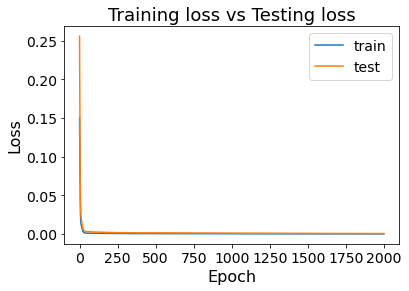

In [36]:
lr = 0.00001
EPOCHS = 2000
model_rnn_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('../saved_model/rnn.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                          callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [37]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/rnn.h5')

#### Test set

In [38]:
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [39]:
# inv_y

In [40]:
# inv_yhat

In [41]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [42]:
error = inv_yhat - inv_y
# error

In [43]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [44]:
len(error_19_20)

17544

In [45]:
inv_y.to_csv('../output/inv_y_rnn.csv')
inv_yhat.to_csv('../output/inv_yhat_rnn.csv')
error.to_csv('../output/error_rnn.csv')

### Performance

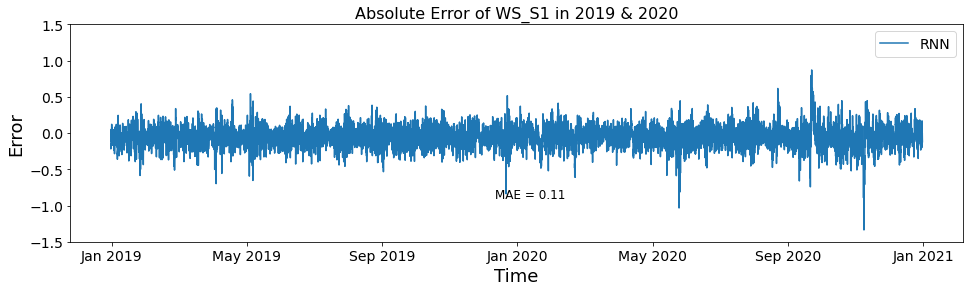

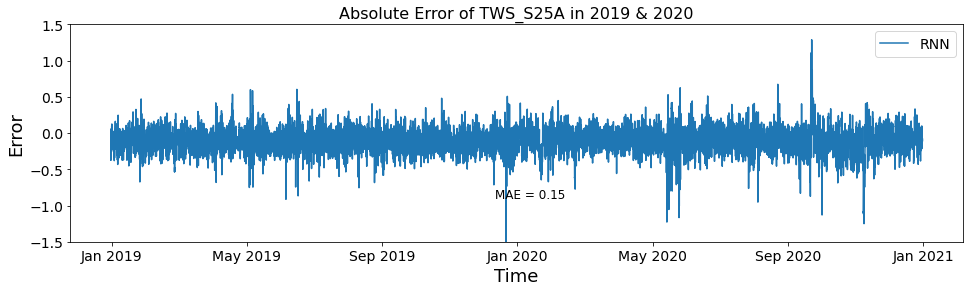

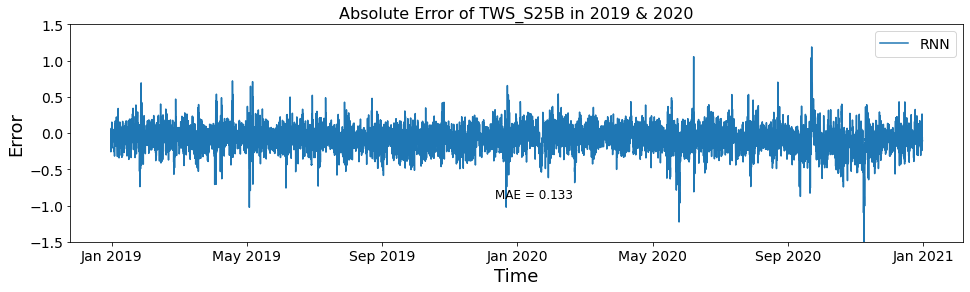

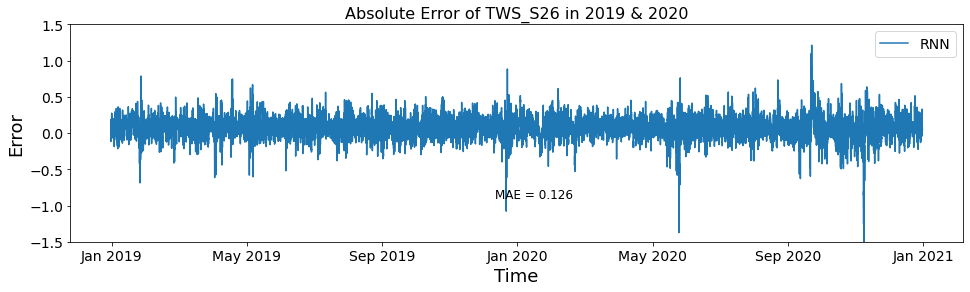

In [46]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error.iloc[-17544:, col], label='RNN')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.5, 1.5)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -0.9, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()

In [47]:
error_24th_hour = error.iloc[:, [-4, -3, -2, -1]]  # last 4 columns --> t+12
error_24th_hour

,92,93,94,95
0,-0.117013,-0.130987,-0.100062,0.042347
1,-0.017361,-0.010659,-0.024199,0.101930
2,-0.122361,-0.163794,-0.089317,-0.015772
3,-0.190012,-0.287452,-0.174751,-0.084226
4,-0.296929,-0.373611,-0.274865,-0.187746
...,...,...,...,...
19244,-0.014314,-0.113765,-0.079441,0.103347
19245,-0.000705,-0.111108,-0.054970,0.106533
19246,-0.086495,-0.118453,-0.115762,0.049114
19247,-0.087879,-0.074172,-0.107624,0.100689


In [48]:
# error.rename(columns = {'11':'WS_S1', '23':'TWS_S25A', '35':'TWS_S25B', '47':'TWS_S26'}, inplace = True)

In [49]:
error_24th_hour.columns = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
error_24th_hour

,WS_S1,TWS_S25A,TWS_S25B,TWS_S26
0,-0.117013,-0.130987,-0.100062,0.042347
1,-0.017361,-0.010659,-0.024199,0.101930
2,-0.122361,-0.163794,-0.089317,-0.015772
3,-0.190012,-0.287452,-0.174751,-0.084226
4,-0.296929,-0.373611,-0.274865,-0.187746
...,...,...,...,...
19244,-0.014314,-0.113765,-0.079441,0.103347
19245,-0.000705,-0.111108,-0.054970,0.106533
19246,-0.086495,-0.118453,-0.115762,0.049114
19247,-0.087879,-0.074172,-0.107624,0.100689


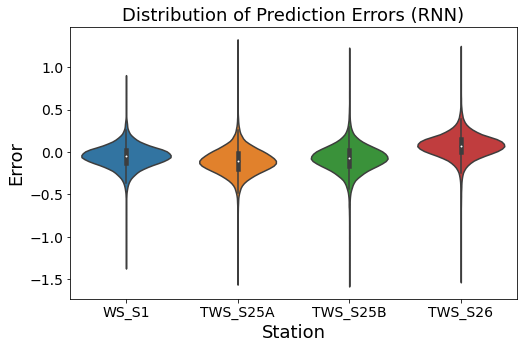

In [50]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 5)
# plt.grid()
plt.xlabel('Station', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of Prediction Errors (RNN)', fontsize='18')
ax = sns.violinplot(data=error_24th_hour[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']])